# libraries, data input and preprocessing


In [799]:
import numpy as np 
import pandas as pd
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras_visualizer import visualizer
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from keras.layers import BatchNormalization
import os
from sklearn.metrics import classification_report

In [800]:
data_path = 'dataset/jaffedbase/jaffedbase'
data_dir_list = os.listdir(data_path)

names = ['happy', 'sad', 'surprise', 'angry', 'disgust', 'fear', 'neutral']
labels = []
img_data_list=[]

img_list=os.listdir(data_path)
print ('Loaded the images of dataset-'+'{}'.format(data_path))
del img_list[0]
del img_list[0]
for img in img_list:
    input_img=cv2.imread(data_path + '/'+ img )
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(48,48))
    img_data_list.append(input_img_resize)
    if 'AN' in img.split('.')[1]:
        labels.append(names.index('angry'))
    elif 'HA' in img.split('.')[1]:
        labels.append(names.index('happy'))
    elif 'SA' in img.split('.')[1]:
        labels.append(names.index('sad'))
    elif 'NE' in img.split('.')[1]:
        labels.append(names.index('neutral'))
    elif 'SU' in img.split('.')[1]:
        labels.append(names.index('surprise'))
    elif 'DI' in img.split('.')[1]:
        labels.append(names.index('disgust'))
    elif 'FE' in img.split('.')[1]:
        labels.append(names.index('fear'))
# print(labels)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
X = img_data
num_classes = len(names)
Y = utils.to_categorical(labels, len(names))

Loaded the images of dataset-dataset/jaffedbase/jaffedbase


In [801]:
def getLabel(id):
    return names[id]

In [802]:
X_train, X_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.30, shuffle=True, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], 48, 48, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 48, 48, 1))

print(X_train.shape)
print(X_test.shape)

(149, 48, 48, 1)
(64, 48, 48, 1)


# model 

In [803]:
input_shape=(48,48,1)

model = Sequential()

model.add(Conv2D(6,(6,6), input_shape=input_shape))
model.add(Conv2D(2,(2,2), input_shape=input_shape))
model.add(Conv2D(4,(2,2), input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(4,(2,2), input_shape=input_shape))

model.add(Flatten())
model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_235 (Conv2D)          (None, 43, 43, 6)         222       
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 42, 42, 2)         50        
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 41, 41, 4)         36        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 20, 20, 4)         0         
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 19, 19, 4)         68        
_________________________________________________________________
flatten_94 (Flatten)         (None, 1444)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 7)               

## compile and fit model

In [804]:
filename='model_train_new.csv'
filepath = os.path.join("./emotion_detector_models_jaffe/model_v6_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')

In [805]:
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

In [806]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'MeanSquaredError'])

In [807]:
model_info = model.fit(X_train, y_train, batch_size=7, epochs=80, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/80
22/22 [==============================] - 3s 57ms/step - loss: 1.9686 - accuracy: 0.1678 - mean_squared_error: 0.1234 - val_loss: 1.9546 - val_accuracy: 0.2344 - val_mean_squared_error: 0.1226
Epoch 2/80
22/22 [==============================] - 1s 28ms/step - loss: 1.9203 - accuracy: 0.2013 - mean_squared_error: 0.1213 - val_loss: 1.8970 - val_accuracy: 0.2500 - val_mean_squared_error: 0.1204
Epoch 3/80
22/22 [==============================] - 1s 28ms/step - loss: 1.8417 - accuracy: 0.3893 - mean_squared_error: 0.1175 - val_loss: 1.8748 - val_accuracy: 0.1562 - val_mean_squared_error: 0.1199
Epoch 4/80
22/22 [==============================] - 1s 29ms/step - loss: 1.7716 - accuracy: 0.3221 - mean_squared_error: 0.1148 - val_loss: 1.7868 - val_accuracy: 0.3906 - val_mean_squared_error: 0.1149
Epoch 5/80
22/22 [==============================] - 1s 28ms/step - loss: 1.6200 - accuracy: 0.5034 - mean_squared_error: 0.1065 - val_loss: 1.7152 - val_accuracy: 0.3438 - val_mean_squared

## score and plots

In [808]:
score = model.evaluate(X_train, y_train)
print('Accuracy (train): %.2f' % (score[1]*100))

score = model.evaluate(X_test, y_test)
print('Accuracy (test): %.2f' % (score[1]*100))

5/5 [==============================] - 0s 18ms/step - loss: 4.6053e-04 - accuracy: 1.0000 - mean_squared_error: 1.8352e-07
Accuracy (train): 100.00
2/2 [==============================] - 1s 21ms/step - loss: 1.1860 - accuracy: 0.8750 - mean_squared_error: 0.0328
Accuracy (test): 87.50


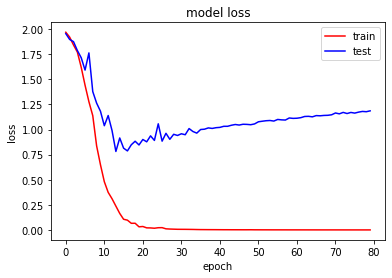

In [809]:
plt.plot(model_info.history['loss'], 'r', label='train')
plt.plot(model_info.history['val_loss'], 'b', label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

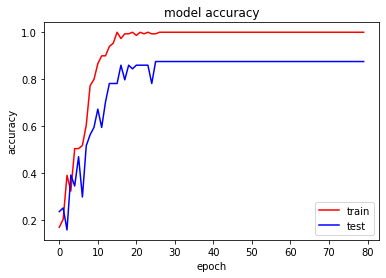

In [810]:
plt.plot(model_info.history['accuracy'], 'r', label='train')
plt.plot(model_info.history['val_accuracy'], 'b', label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [811]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

In [812]:
y_pred = utils.to_categorical(y_pred, num_classes)

In [813]:
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       happy       1.00      0.90      0.95        10
         sad       0.78      0.88      0.82         8
    surprise       0.90      1.00      0.95         9
       angry       1.00      0.70      0.82        10
     disgust       0.56      0.83      0.67         6
        fear       1.00      0.83      0.91        12
     neutral       0.90      1.00      0.95         9

   micro avg       0.88      0.88      0.88        64
   macro avg       0.88      0.88      0.87        64
weighted avg       0.90      0.88      0.88        64
 samples avg       0.88      0.88      0.88        64



In [814]:
def title(y_pred, y_test, target_names, i):
    pred_name = names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [815]:
y_pred = [np.where(i == 1)[0][0] for i in y_pred]
y_test = [np.where(i == 1)[0][0] for i in y_test]

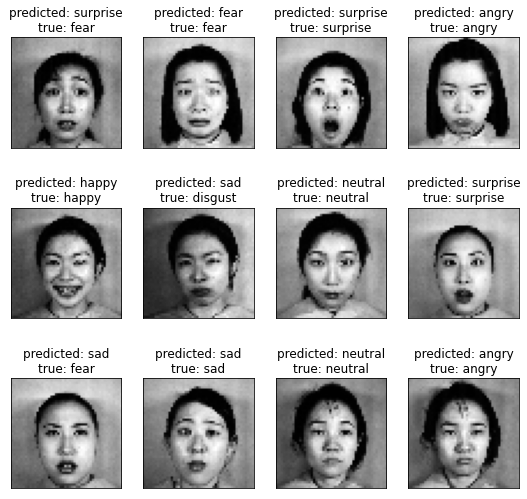

In [816]:
prediction_titles = [title(y_pred, y_test, names, i) for i in range(len(y_pred))]
plot_gallery(X_test, prediction_titles, 48, 48)